In [1]:
%%capture
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install openpyxl

In [2]:
max_calculated = pd.read_csv('max_calculated.csv')
max_elemental = pd.read_csv('max_elemental.csv')
list_mxene = pd.read_excel('synthesized-MXenes-MAX.xlsx',sheet_name=0)
list_failed = pd.read_excel('synthesized-MXenes-MAX.xlsx', sheet_name=2)
n_samples = max_elemental.shape[0]
synth_list = pd.unique(list_mxene['MXene'])[:-1]
to_drop = list(range(167,173))
mx_ene_df = list_mxene.drop(labels = to_drop, axis='index')
mx_ene_df = mx_ene_df.drop(['Unnamed: 9','Unnamed: 12','Notes','status','Reference method'],axis=1)
max_elemental['class'] = np.zeros(max_elemental.shape[0])
parents = mx_ene_df['Parent material'].unique()
banned_words = ['+','Mxene','topochemical','reaction', 'or',
               'synthesis','MXene','direct']
complete_parents = []
for i in range(len(parents)):
    inter = parents[i].split()
    for word in range(len(inter)):
        if inter[word] not in banned_words:
            complete_parents.append(inter[word])


for i in range(max_elemental.shape[0]):
    if max_elemental.loc[i,'compound_formula'] in complete_parents:
        max_elemental.loc[i,'class'] = 1

max_elemental = max_elemental.set_index('compound_formula',drop=True)
max_elemental = max_elemental.drop(['M_element', 'A_element', 'X_element'],axis=1)
max_calculated = max_calculated.set_index('prettyformula',drop=True)
whole_data = max_elemental.merge(max_calculated,how='inner',
                                 left_index=True,right_index=True)

In [3]:
svm = pd.read_csv('it_ls_svm_all_features.csv')
bagging = pd.read_csv('ordered_predictions_bagging_svm_15_all_features.csv')

In [4]:
svm = svm.filter(items=['compound_name'],axis=1)

In [5]:
svm['rank_svm'] = svm.index

In [6]:
bagging = bagging.drop(['score_bagging'],axis=1)
#bagging : compound_name
#svm : 

In [7]:
list_svm = list(svm['compound_name'])
list_bagging = list(bagging['compound_name'])

In [8]:
list_common = []
common = 0
for i in list_svm:
    if i in list_bagging:
        list_common.append(i)

In [9]:
list_common

['Hf2RuN',
 'Zr2IrN',
 'Ti2RhC',
 'Zr2SnC',
 'Hf2GeN',
 'Ti2NiN',
 'Zr2OsN',
 'Zr2AlN',
 'Ti2RuC',
 'Nb2SC',
 'Ti2SiC',
 'V2IrN',
 'V2RuN',
 'Zr2SnN',
 'V2OsN',
 'Nb2SiC',
 'Hf2SeN']

In [10]:
positive_ones = whole_data[whole_data['class'] == 1]
positive_ones = positive_ones.filter(['dH','dEf'],axis=1)

In [11]:
max_bagg = max_calculated.filter(items=list_bagging,axis=0)
max_it = max_calculated.filter(items=list_svm,axis=0)

In [12]:
max_bagg = max_bagg.filter(['dH','dEf'],axis=1)
max_it = max_it.filter(['dH','dEf'],axis=1)
if len(list_common)>0:
    max_bagg = max_bagg.drop(list_common,axis=0)
    max_it = max_it.drop(list_common,axis=0)
    common_retained = max_calculated.filter(items=list_common,axis=0)

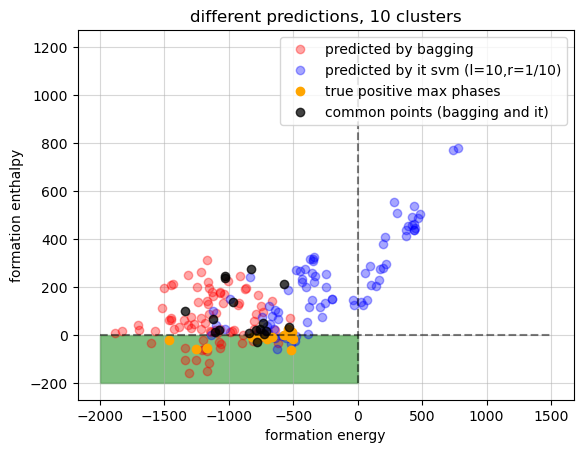

In [13]:
fig, ax = plt.subplots()
ax.plot(max_bagg['dEf'].to_numpy(),max_bagg['dH'].to_numpy(), 'o',
       alpha=0.35,color='red',label='predicted by bagging')
ax.plot(max_it['dEf'].to_numpy(),max_it['dH'].to_numpy(), 'o',
       alpha=0.35,color='blue',label='predicted by it svm (l=10,r=1/10)')
ax.plot(positive_ones['dEf'].to_numpy(),positive_ones['dH'].to_numpy(), 'o',
        color='orange',label='true positive max phases')
if len(list_common)>0:
    ax.plot(common_retained['dEf'].to_numpy(),common_retained['dH'].to_numpy(), 'ko',
            label='common points (bagging and it)',alpha=0.74)
ax.fill_between(np.linspace(-2000,0,2,endpoint=True),
                y1=-200,y2=0,color='green',alpha=0.5)
ax.plot(np.linspace(-2000,1500,2,endpoint=True),np.zeros(2),'--k',alpha=0.5)
ax.plot(np.zeros(2),np.linspace(-200,1200,2,endpoint=True),'--k',alpha=0.5)
ax.grid(alpha=0.5)
ax.set_xlabel(xlabel='formation energy')
ax.set_ylabel(ylabel='formation enthalpy')
ax.set_title('different predictions, 10 clusters')
plt.legend()      
plt.savefig('diff_pred_10_10_cl_elem_10.png')

In [14]:
plausible = common_retained[common_retained['dH']<30]
plausible = plausible[plausible['dEf'] < 0]
list_plausible = plausible.index

In [15]:
plausible

,n,a,c,dMX,dMM,dMA,dAA,rMX,rMA,e_M,...,volume.pa,density,dEf,E_pa,dH,M,A,X,PU_label,year
Zr2SnC,1,3.38626,14.7302,1.25177,2.50354,2.43078,7.36510,2.32146,3.11945,1.47260,...,18.284755,7.110149,-785.437875,-8.364054,-27.989604,Zr,Sn,C,1.0,1963.0
Zr2AlN,1,3.26266,14.4285,1.28370,2.56741,2.32342,7.21425,2.27952,2.99109,1.33810,...,16.626768,5.578732,-1077.299826,-8.371668,21.763031,Zr,Al,N,0.0,NaN
Nb2SC,1,3.31688,11.7331,1.11910,2.23821,1.81417,5.86655,2.21802,2.63789,1.44904,...,13.973747,6.829430,-760.998292,-9.152456,23.364135,Nb,S,C,1.0,1968.0
Ti2SiC,1,3.05308,12.8515,1.17784,2.35568,2.03504,6.42575,2.12000,2.69230,1.39677,...,12.967866,4.348268,-792.226312,-8.402293,19.030655,Ti,Si,C,0.0,NaN
V2IrN,1,2.85496,12.9868,1.10738,2.21477,2.13932,6.49340,1.98575,2.70067,1.27662,...,11.458875,11.162172,-842.295871,-9.677205,9.977297,V,Ir,N,0.0,NaN
V2RuN,1,2.85368,12.9030,1.12346,2.24693,2.10229,6.45150,1.99416,2.67098,1.18387,...,11.374783,7.918185,-712.557425,-9.656456,15.787383,V,Ru,N,0.0,NaN
Zr2SnN,1,3.32086,14.7263,1.26190,2.52379,2.41968,7.36315,2.29531,3.08721,1.38620,...,17.580626,7.442053,-1107.578601,-8.463626,14.129296,Zr,Sn,N,0.0,NaN
V2OsN,1,2.84484,13.0117,1.12603,2.25207,2.12689,6.50585,1.99139,2.68726,1.22935,...,11.399573,11.147878,-726.173787,-10.158309,2.171020,V,Os,N,0.0,NaN
